# Binary Classification Workflow: Scikit Learn

Notebook Contents:
* [EDA](#scrollTo=03asMvbvwinC)
  * [Categorical Feature Analysis](#scrollTo=7OR4j0aYsFVr)
  * [Numeric Feature Analysis](#scrollTo=AVQ0_NuNsN28)
* [Data Overview](#scrollTo=HtYdoF-M0C_k)
* [Data Preprocessing](#scrollTo=-pmv9kZAJsox)
* [Evaluation Metrics](#scrollTo=DS1j8mETT0VG)
* [Threshold Tuning](#scrollTo=d6d-iD8bXLgE)
* [Cross Validation](#scrollTo=9_NQaUEcbjLr)
* [Hyperparameter Tuning](#scrollTo=C5JHsnoLMt_N)
* [Feature Importance](#scrollTo=gx6eghfVhY6y)
* [Feature Prediction Diagnostics](#scrollTo=V5bpZPGZ0FSU)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # or any classifier
import warnings
import math
# warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Google Drive: Mounting Google Drive locally

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read from
path = '/content/drive/MyDrive/Colab/Datasets/telco-customer-churn.csv'
# path = '/data/telco-customer-churn.csv'

df = pd.read_csv(path)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype('float')
df.reset_index(drop=True, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# EDA

In [ ]:
# !pip install ydata_profiling

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Profiling Report")

In [ ]:
# profile

## Categorical Feature Analysis

Overall target mean: 26.58%


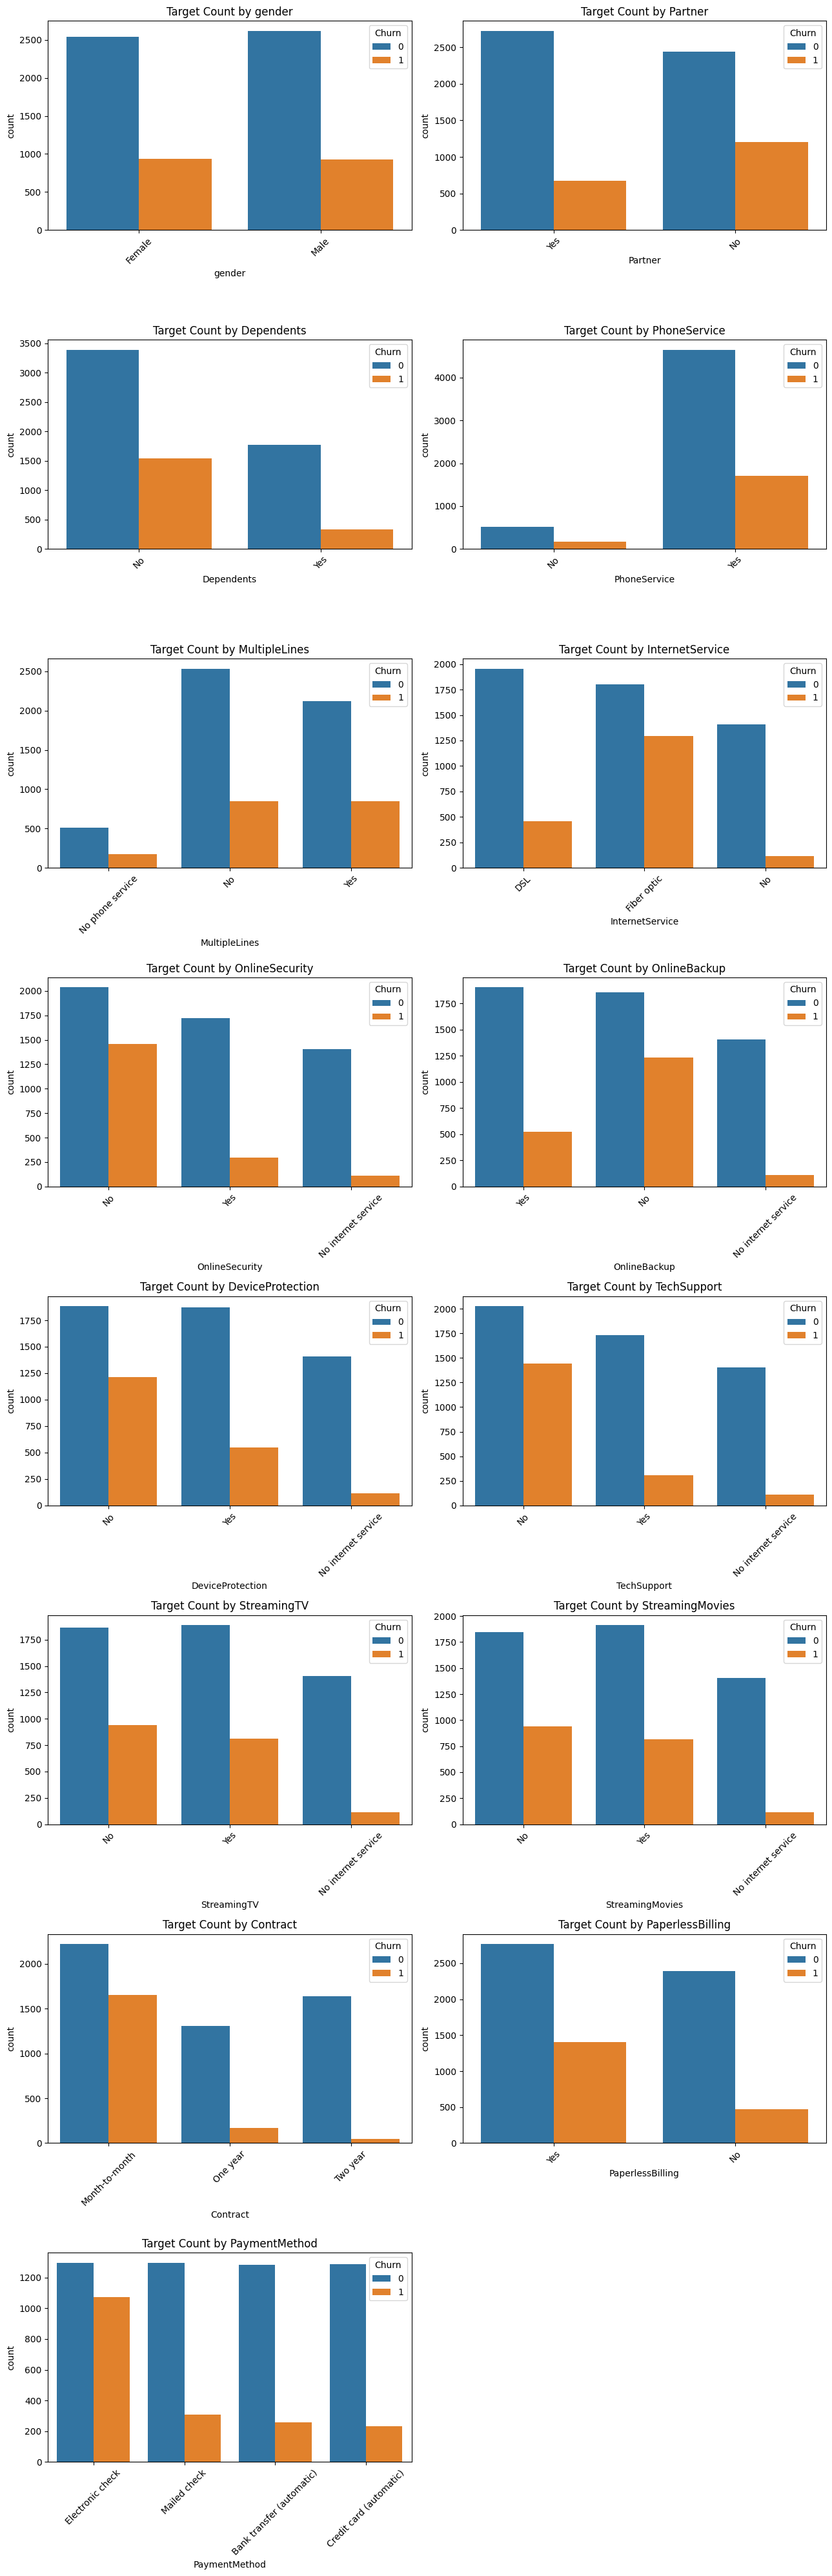

In [ ]:
# Mean target
target = 'Churn'
mean_target = df[target].mean()
print(f"Overall target mean: {mean_target:.2%}")


# Number of plots and grid shape
cols_to_remove = ['customerID']
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
filtered_cols = [item for item in cat_cols if item not in cols_to_remove]
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.5, rows * 5))
axes = axes.flatten()

# Plot each categorical variable
for i, col in enumerate(filtered_cols):
    sns.countplot(data=df, x=col, hue=target, ax=axes[i])
    axes[i].set_title(f'Target Count by {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

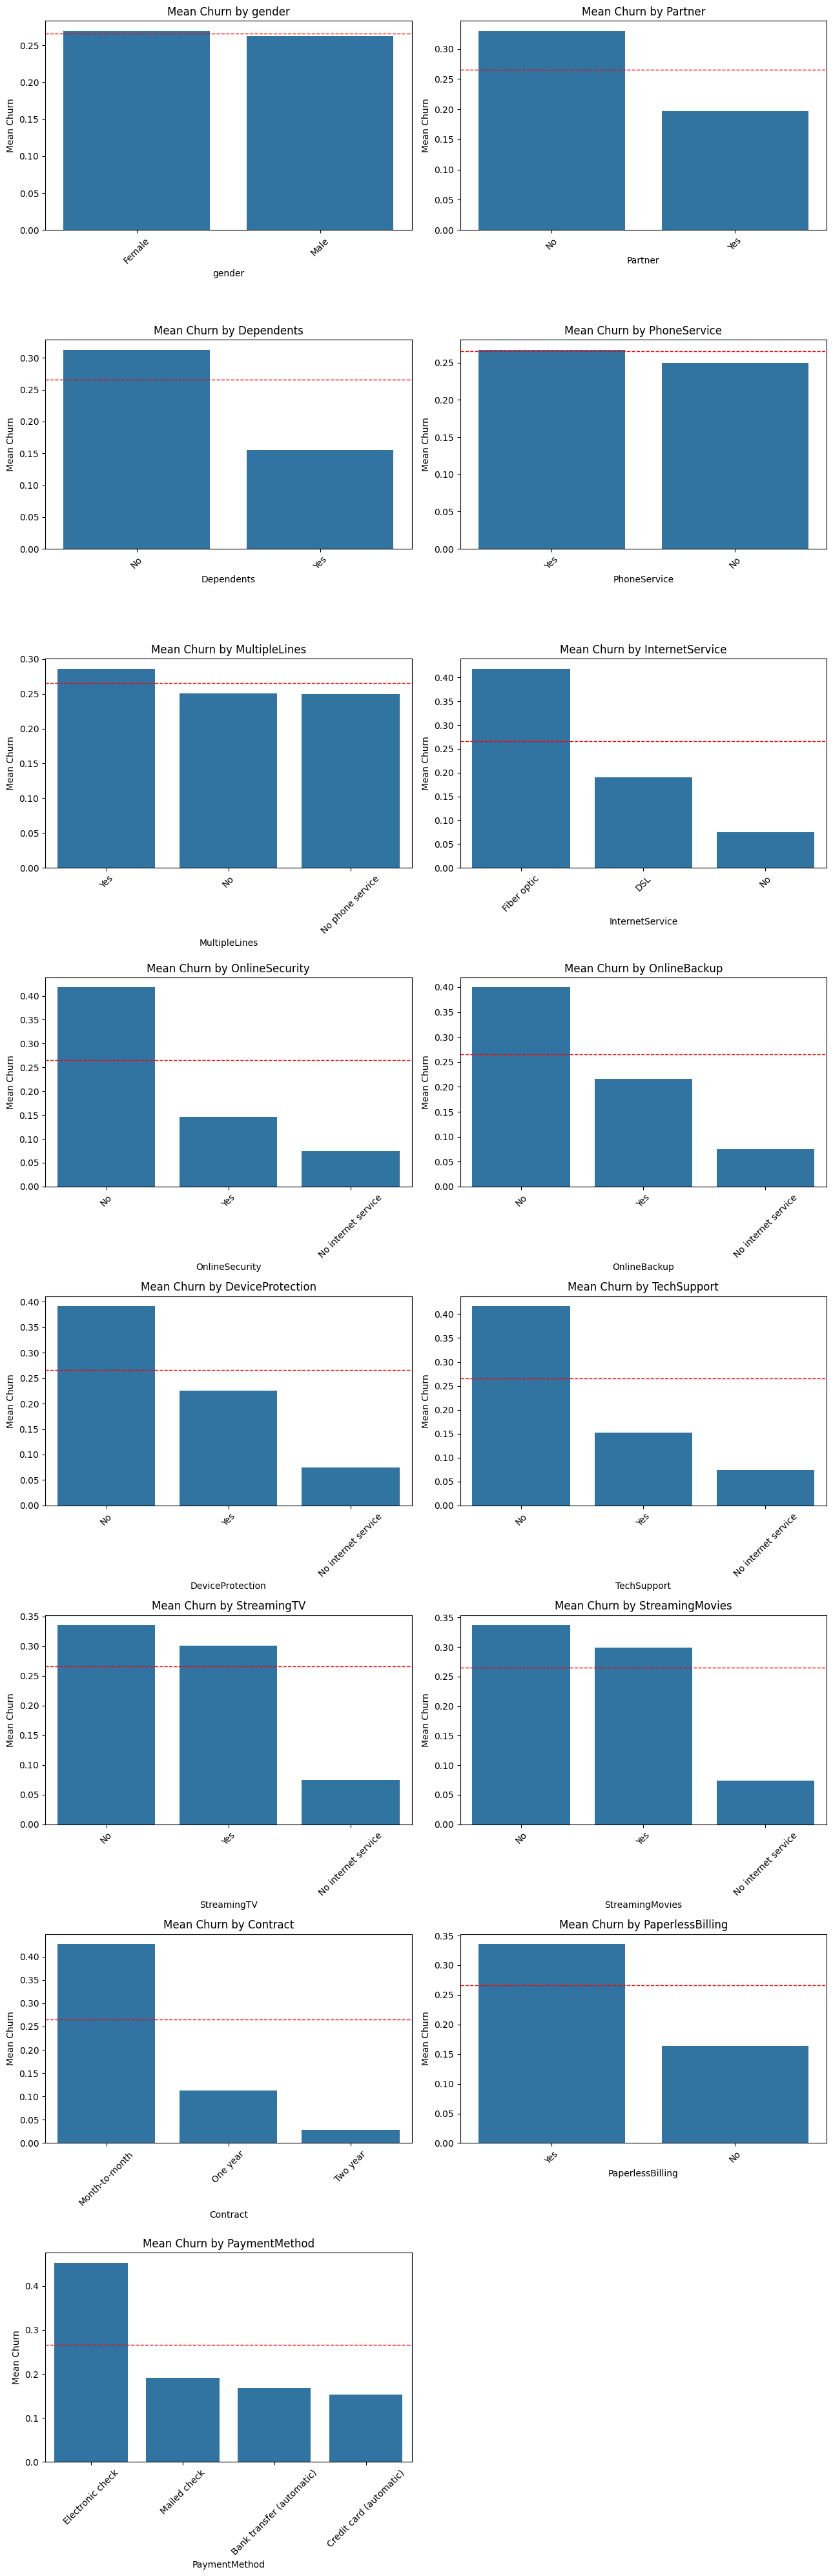

In [ ]:
# plot mean target across all categorical variables
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6.5, rows * 5))
axes = axes.flatten()

# Plot mean target for each category
for i, col in enumerate(filtered_cols):
    # Calculate mean target per category
    grouped = df.groupby(col)[target].mean().reset_index()

    # Sort categories by mean value (optional for clarity)
    grouped = grouped.sort_values(by=target, ascending=False)

    sns.barplot(data=grouped, x=col, y=target, ax=axes[i])
    axes[i].set_title(f'Mean {target} by {col}')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].axhline(mean_target, color='red', linestyle='--', linewidth=1)
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_xlabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Numeric Feature Analysis

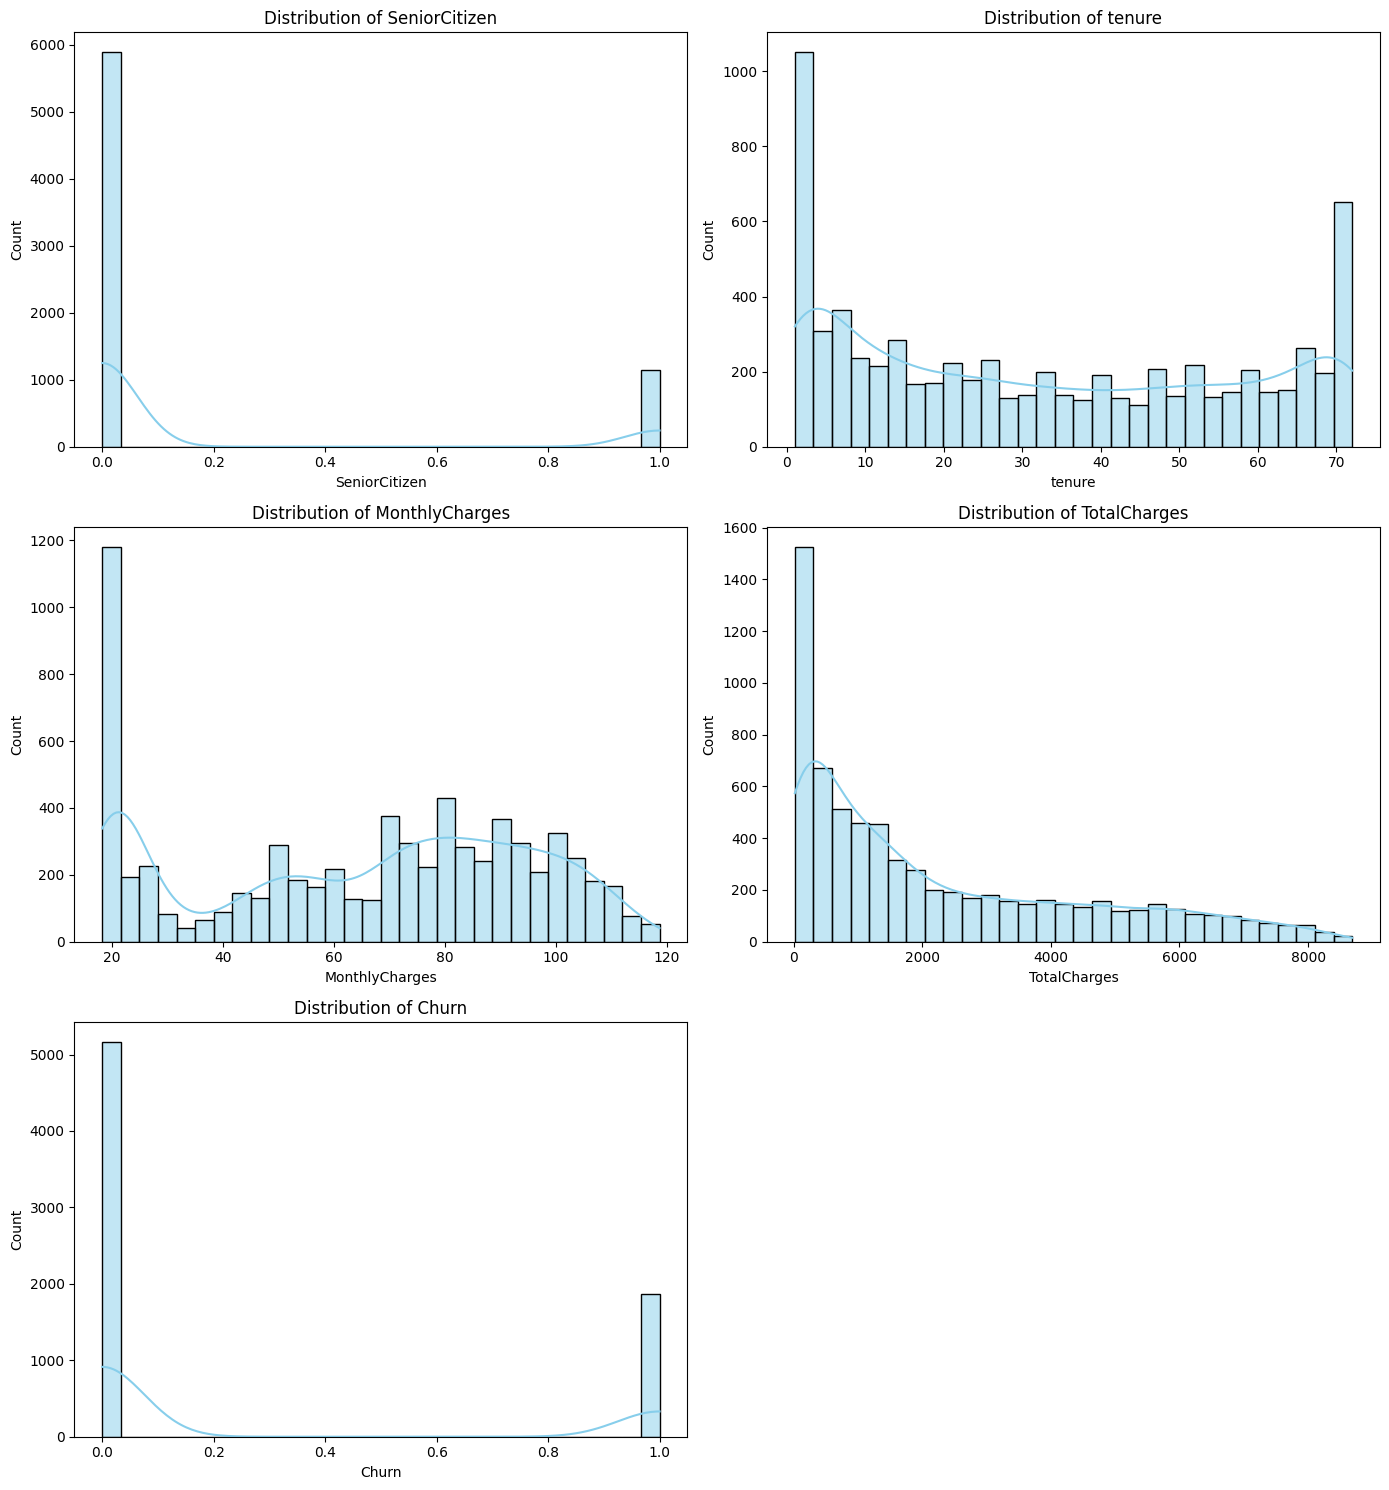

In [ ]:
# # Optional: columns to exclude
# cols_to_remove = ['customerID', 'some_other_column']  # <-- adjust as needed

# Select numeric features
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature with KDE
for i, col in enumerate(filtered_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

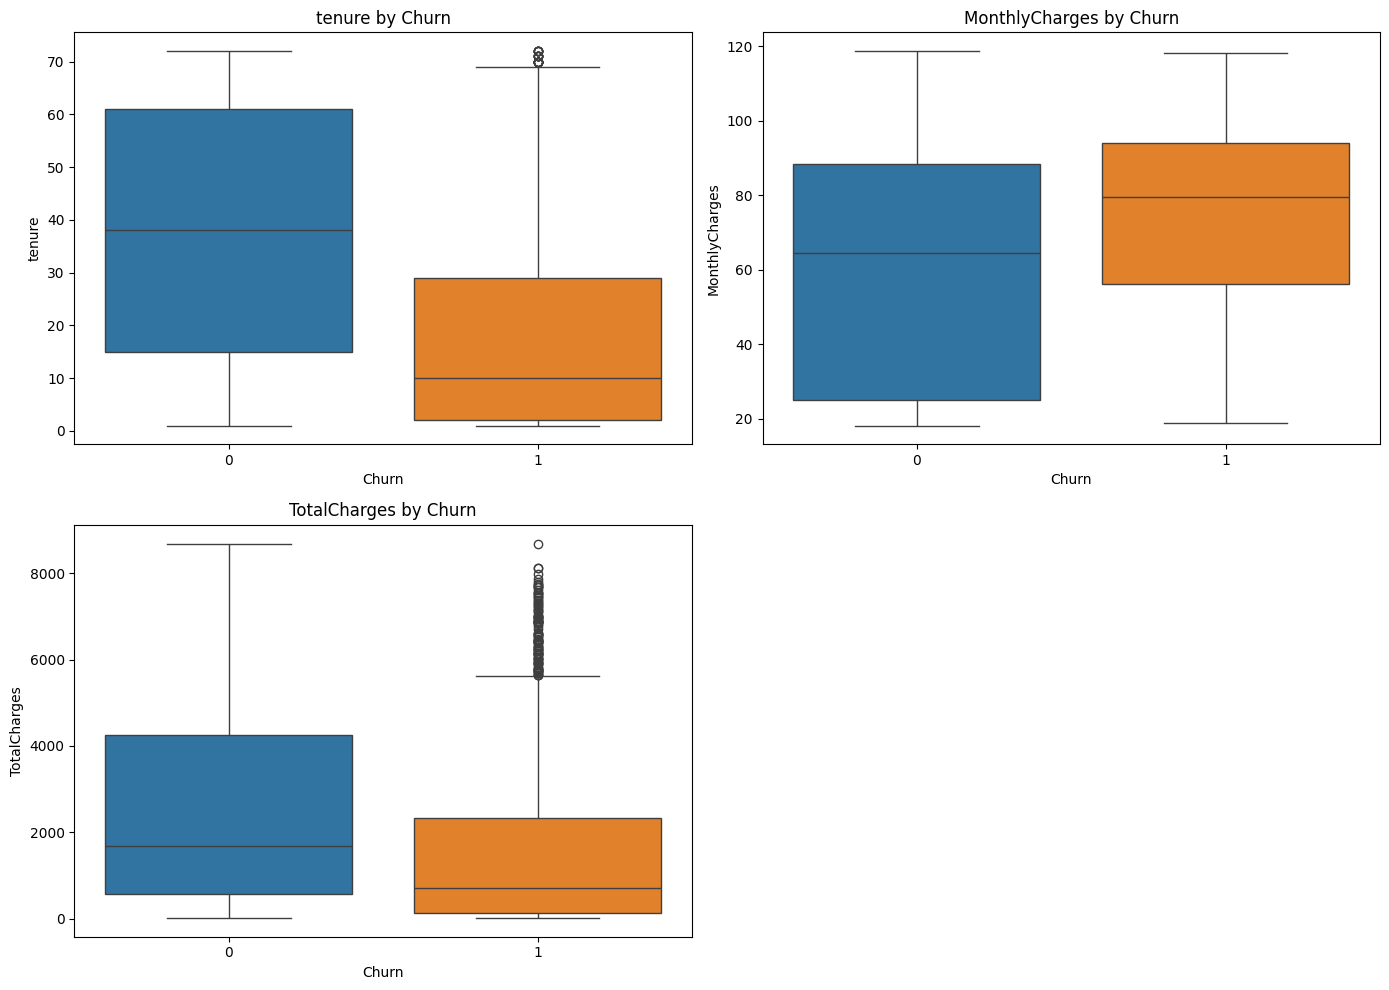

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Define your target variable
target = 'Churn'  # Replace with your actual target name

# Optional: columns to exclude
cols_to_remove = ['Churn', 'SeniorCitizen']  # Customize this list

# Select numeric features (and remove excluded ones)
num_cols = df.select_dtypes(include='number').columns.tolist()
filtered_cols = [col for col in num_cols if col not in cols_to_remove]

# Subplot layout
n = len(filtered_cols)
cols = 2
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5))
axes = axes.flatten()

# Plot each numeric feature as a boxplot
for i, col in enumerate(filtered_cols):
    sns.boxplot(data=df, x=target, y=col, ax=axes[i], hue=target, legend=False)
    axes[i].set_title(f'{col} by {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(col)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show();

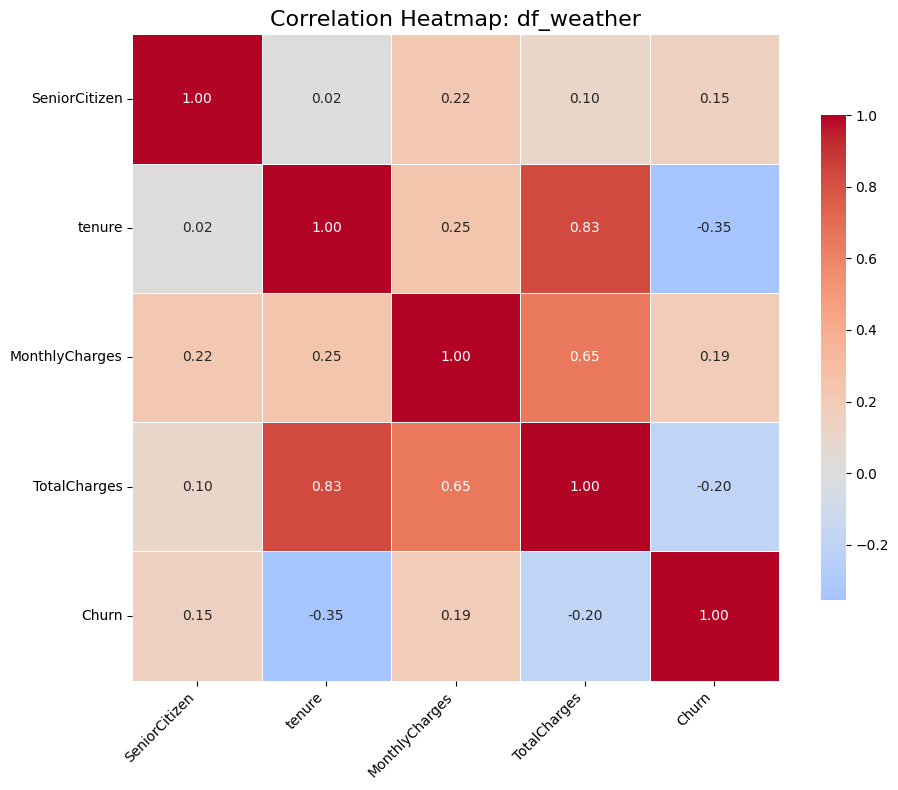

In [ ]:
# correlation matrix
corr_matrix = df.corr(numeric_only=True)  # Use numeric_only=True for pandas >=1.5

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # Show correlation coefficients
    cmap='coolwarm',  # Color map
    center=0,         # Center the colormap at zero
    fmt=".2f",        # Format the numbers to 2 decimal places
    square=True,      # Make cells square
    linewidths=0.5,   # Cell border lines
    cbar_kws={"shrink": 0.75}  # Shrink color bar
)
plt.title("Correlation Heatmap: df_weather", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Data Overview

Categorical (2 levels):
* gender
* Partner
* Dependents
* PhoneService
* PaperlessBilling

Categorical (>2 levels):
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies
* Contract
* PaymentMethod

Numeric:
* SeniorCitizen
* tenure
* MonthlyCharges
* TotalCharges

Target
* Churn (Categorical - 2 levels)





---

# Data Preparation

In [ ]:
df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   int64  
 16  PaperlessBilling  7032 non-null   object 


# Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # or any classifier

In [ ]:
target = ['Churn']
cols_to_drop = ['customerID']

binary_int_cols = ['SeniorCitizen']
ordinal_int_cols = ['Contract']

numeric_cols = [
'tenure',
'MonthlyCharges',
'TotalCharges',
]

binary_categorical_cols = [
'gender',
'Partner',
'Dependents',
'PhoneService',
'PaperlessBilling'
]

categorical_cols = [
'MultipleLines',
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection',
'TechSupport',
'StreamingTV',
'StreamingMovies',
'PaymentMethod',
]

In [ ]:
# --- 1. Split features and target ---
drop_cols = cols_to_drop + target
X = df.drop(columns=drop_cols)
y = df[target]

In [ ]:
# --- 2. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# --- 3. Define transformers ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])
    # Silently ignore unknown categories at transform time
    # Drop one of the two levels of a categorical feature only if that feature has exactly two categories

In [ ]:
# --- 4. Column transformer for preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('bin_cat', categorical_transformer, binary_categorical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # Let binary_int_cols and ordinary_int_cols through as-is
)

In [ ]:
# --- 5. Fit preprocessing pipeline only ---
preprocessor.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('bin_cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'PaperlessBilling']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['MultipleLines', 'InternetService',
                                  'OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies',
                                  'PaymentMethod'])])

In [ ]:
print(preprocessor.n_features_in_)
print(preprocessor.feature_names_in_)

19
['gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure' 'PhoneService'
 'MultipleLines' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'Contract' 'PaperlessBilling' 'PaymentMethod' 'MonthlyCharges'
 'TotalCharges']


In [ ]:
preprocessor.get_feature_names_out()

array(['num__tenure', 'num__MonthlyCharges', 'num__TotalCharges',
       'bin_cat__gender_Male', 'bin_cat__Partner_Yes',
       'bin_cat__Dependents_Yes', 'bin_cat__PhoneService_Yes',
       'bin_cat__PaperlessBilling_Yes', 'cat__MultipleLines_No',
       'cat__MultipleLines_No phone service', 'cat__MultipleLines_Yes',
       'cat__InternetService_DSL', 'cat__InternetService_Fiber optic',
       'cat__InternetService_No', 'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No',
       'cat__OnlineBackup_No internet service', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__StreamingTV_Yes', 'cat__StreamingMovies_No',
       'cat__Streaming

In [ ]:
preprocessor.get_params()

{'force_int_remainder_cols': True,
 'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('num',
   Pipeline(steps=[('scaler', StandardScaler())]),
   ['tenure', 'MonthlyCharges', 'TotalCharges']),
  ('bin_cat',
   Pipeline(steps=[('onehot',
                    OneHotEncoder(drop='if_binary', handle_unknown='ignore'))]),
   ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']),
  ('cat',
   Pipeline(steps=[('onehot',
                    OneHotEncoder(drop='if_binary', handle_unknown='ignore'))]),
   ['MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'PaymentMethod'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'num': Pipeline(steps=[('scaler', StandardScaler())]),
 'bin_cat': Pipeline(steps=[('onehot',
                  OneHotEncoder(drop='if_binary', handle_unknown='ig

In [ ]:
# --- 6. Transform train and test data ---
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# --- 7. Fit model separately ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train_preprocessed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [ ]:
# --- 8. Predict on test set ---
y_pred = model.predict(X_test_preprocessed)

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# provides probablity for each class
y_pred_prob = model.predict_proba(X_test_preprocessed)

In [ ]:
print(y_pred_prob.shape)
print(model.classes_)
y_pred_prob

(1407, 2)
[0 1]


array([[1.  , 0.  ],
       [0.19, 0.81],
       [0.98, 0.02],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.98, 0.02]])

In [ ]:
pd.DataFrame(y_pred_prob).describe()

,0,1
count,1407.000000,1407.000000
mean,0.721360,0.278640
std,0.273453,0.273453
min,0.000000,0.000000
25%,0.560000,0.040000
50%,0.800000,0.200000
75%,0.960000,0.440000
max,1.000000,1.000000


In [ ]:
col_names = list(preprocessor.get_feature_names_out())
df_X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=col_names)
df_X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed, columns=col_names)

In [ ]:
print(df_X_train_preprocessed.shape)
print(df_X_test_preprocessed.shape)
print(y_train.shape)
print(y_test.shape)

df_X_train_preprocessed.head()

(5625, 38)
(1407, 38)
(5625, 1)
(1407, 1)


,num__tenure,num__MonthlyCharges,num__TotalCharges,bin_cat__gender_Male,bin_cat__Partner_Yes,bin_cat__Dependents_Yes,bin_cat__PhoneService_Yes,bin_cat__PaperlessBilling_Yes,cat__MultipleLines_No,cat__MultipleLines_No phone service,cat__MultipleLines_Yes,cat__InternetService_DSL,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__PaymentMethod_Bank transfer (automatic),cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Contract
0,1.321816,0.981556,1.659900,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,-0.267410,-0.971546,-0.562252,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.444064,0.837066,1.756104,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
3,-1.204646,0.641092,-0.908326,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.669826,-0.808787,-0.101561,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


---

# Evaluation Metrics: Binary Classification

=== Metric Scores ===
Accuracy:  0.790
Precision: 0.636
Recall:    0.495
F1 Score:  0.556
ROC AUC:   0.815
PR AUC:    0.595


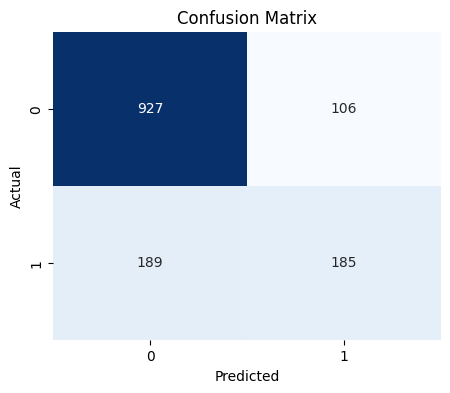

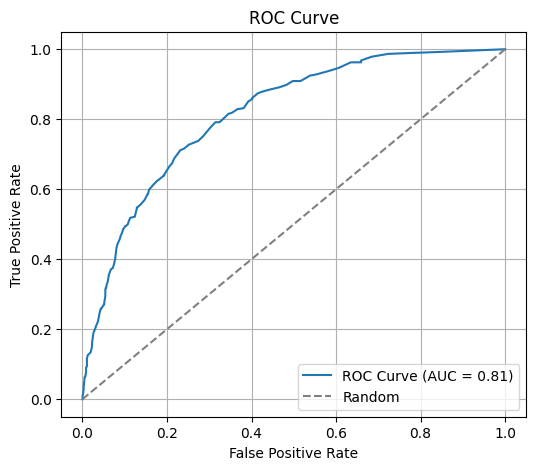

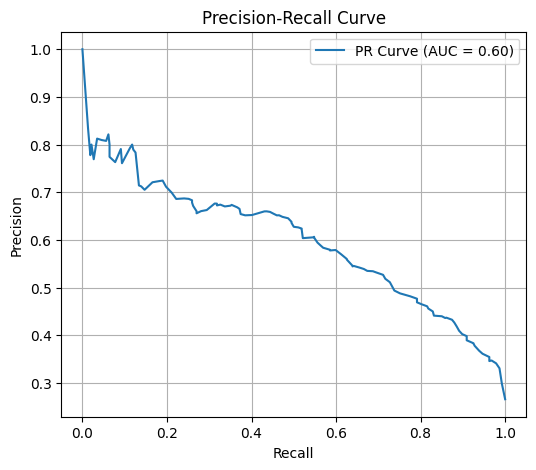


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.831     0.897     0.863      1033
           1      0.636     0.495     0.556       374

    accuracy                          0.790      1407
   macro avg      0.733     0.696     0.710      1407
weighted avg      0.779     0.790     0.781      1407



In [ ]:
# Binary Classification Metrics Visualization Script
# --------------------------------------------------
# Assumes:
# - `y_test`: true labels (0 or 1)
# - `y_pred`: predicted class labels from model
# - `y_pred_prob`: predicted probabilities from model.predict_proba(X_test)[:, 1]

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example placeholders (replace these with your real values)
# y_test = ...
# y_pred = ...

y_pred_prob = model.predict_proba(X_test_preprocessed)[:, 1]

# 1. Basic metric scores
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_prob)
avg_prec  = average_precision_score(y_test, y_pred_prob)

print("=== Metric Scores ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")
print(f"PR AUC:    {avg_prec:.3f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f'PR Curve (AUC = {avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# 5. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))


---

In [ ]:
tpr

array([0.        , 0.01336898, 0.01871658, 0.02139037, 0.02673797,
       0.03475936, 0.05614973, 0.06149733, 0.06417112, 0.06417112,
       0.07754011, 0.09090909, 0.09358289, 0.11229947, 0.11764706,
       0.12032086, 0.12566845, 0.13368984, 0.13903743, 0.14705882,
       0.1657754 , 0.18181818, 0.18983957, 0.19786096, 0.21122995,
       0.22192513, 0.24064171, 0.2513369 , 0.25935829, 0.25935829,
       0.26203209, 0.27005348, 0.27005348, 0.28074866, 0.29411765,
       0.31283422, 0.31818182, 0.31818182, 0.32620321, 0.3368984 ,
       0.35026738, 0.35294118, 0.36631016, 0.37165775, 0.37433155,
       0.38502674, 0.40106952, 0.43048128, 0.43582888, 0.44385027,
       0.45989305, 0.46524064, 0.47326203, 0.48663102, 0.49465241,
       0.49465241, 0.5       , 0.51069519, 0.51871658, 0.51871658,
       0.52139037, 0.54545455, 0.54812834, 0.54812834, 0.55614973,
       0.56417112, 0.56951872, 0.5855615 , 0.5855615 , 0.59893048,
       0.61229947, 0.62566845, 0.62566845, 0.63903743, 0.63903

# Threshold Tuning: Manual

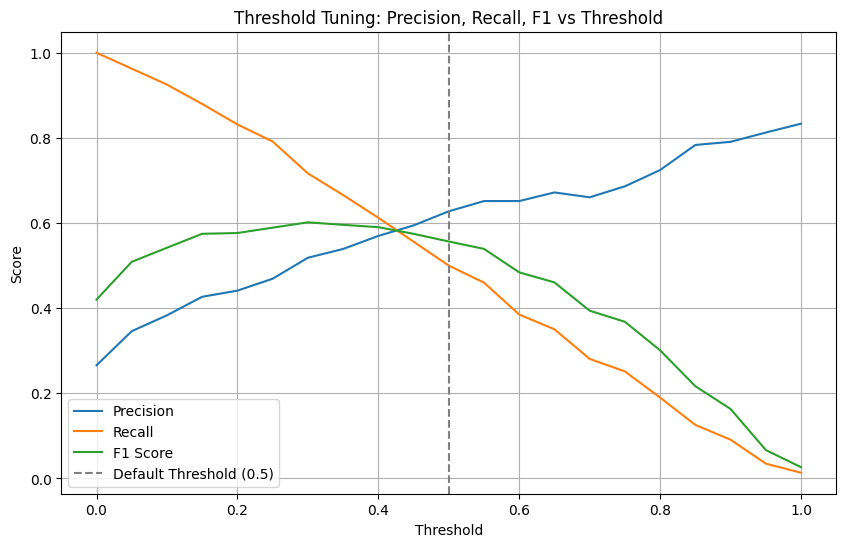

Best threshold for F1 score: 0.30
Precision: 0.518, Recall: 0.717, F1: 0.602
Confusion Matrix at Best Threshold:
[[784 249]
 [106 268]]


In [ ]:
# Threshold Tuning in Binary Classification
# -----------------------------------------
# In binary classification, most classifiers return probabilities.
# By default, a threshold of 0.5 is used to convert probabilities to class labels (0 or 1).
# But in some cases (e.g. imbalanced classes, business costs), we may want to change the threshold.

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np

# # Step 1: Simulate a binary classification dataset
# X, y = make_classification(
#     n_samples=1000, n_features=20, weights=[0.7, 0.3], random_state=42
# )

# # Step 2: Train/Test Split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42
# )

# # Step 3: Fit a classifier
# clf = LogisticRegression()
# clf.fit(X_train, y_train)

# # Step 4: Predict probabilities instead of class labels
y_proba = model.predict_proba(X_test_preprocessed)[:, 1]

# Step 5: Tune threshold manually
thresholds = np.arange(0.0, 1.05, 0.05)  # Try thresholds from 0 to 1
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)  # Apply custom threshold

    # Evaluate metrics at this threshold
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Step 6: Plot Precision/Recall/F1 vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning: Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Pick optimal threshold (e.g., highest F1)
best_thresh_idx = np.argmax(f1s)
best_threshold = thresholds[best_thresh_idx]
print(f"Best threshold for F1 score: {best_threshold:.2f}")
print(f"Precision: {precisions[best_thresh_idx]:.3f}, Recall: {recalls[best_thresh_idx]:.3f}, F1: {f1s[best_thresh_idx]:.3f}")

# Optional: Final Confusion Matrix at best threshold
y_final = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_final)
print("Confusion Matrix at Best Threshold:")
print(cm)

# Cross Validation: No HP Tuning

In [ ]:
# implements KFOLD cross validation on training data set
# use cross_val_score() to evaluate a single metric
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# turning y_train into a 1-D array using .ravel()

scores = cross_val_score(
    model, X_train_preprocessed, y_train.values.ravel(), cv=5, scoring='roc_auc')

print(f'Avg. AUC is: {scores.mean()}')

Avg. AUC is: 0.820921635475799


In [ ]:
scores

array([0.8201835 , 0.83472754, 0.82316357, 0.79767911, 0.82885445])

In [ ]:
# use cross_validate to evaluate a single metric + additional info in addition to the score or multiple metrics
# using cross_validate for multiple metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

# turning y_train into a 1-D array using .ravel()
scoring = ['roc_auc', 'f1']
scores = cross_validate(model, X_train_preprocessed, y_train.values.ravel(), cv=5, scoring=scoring)

sorted(scores.keys())

['fit_time', 'score_time', 'test_f1', 'test_roc_auc']

In [ ]:
print(scores['test_roc_auc'])
print(scores['test_f1'])

[0.8201835  0.83472754 0.82316357 0.79767911 0.82885445]
[0.53283302 0.57786116 0.54444444 0.52091255 0.53631285]


# Hyperparameter Tuning: scikit learn

## GridSearchCV & RandomSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5]
}

model_gridsearch = GridSearchCV(model, param_grid, cv=5)
model_gridsearch.fit(X_train_preprocessed, y_train.values.ravel())

print(model_gridsearch.best_params_)   # Best hyperparameters
print(model_gridsearch.best_estimator_) # Trained model with best settings
print(model_gridsearch.best_score_)

{'max_depth': 5, 'n_estimators': 200}
RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
0.7971555555555556


In [ ]:
model_gridsearch.cv_results_

{'mean_fit_time': array([0.45785336, 0.65510192, 1.23894987, 0.16159148, 0.46810741,
        0.73315854]),
 'std_fit_time': array([0.0089442 , 0.11712673, 0.06536484, 0.00903149, 0.01775471,
        0.13370076]),
 'mean_score_time': array([0.01798339, 0.02478137, 0.05517964, 0.00725088, 0.01921496,
        0.02711983]),
 'std_score_time': array([0.00149626, 0.00030874, 0.00668512, 0.0001445 , 0.00173714,
        0.00406756]),
 'param_max_depth': masked_array(data=[None, None, None, 5, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': None, 'n_estimators': 50},
  {'max_depth': None, 'n_estimators': 100},
  {'max_depth': None, 'n_estimators': 200},
  {'max_depth': 5, 'n_estimators': 50},
  {'max_depth': 5, 'n_estimators': 1

In [ ]:
model_gridsearch.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

# Model Evaluation

=== Metric Scores ===
Accuracy:  0.784
Precision: 0.641
Recall:    0.425
F1 Score:  0.511
ROC AUC:   0.833
PR AUC:    0.639


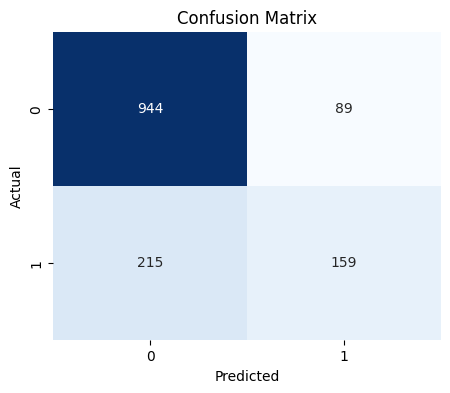

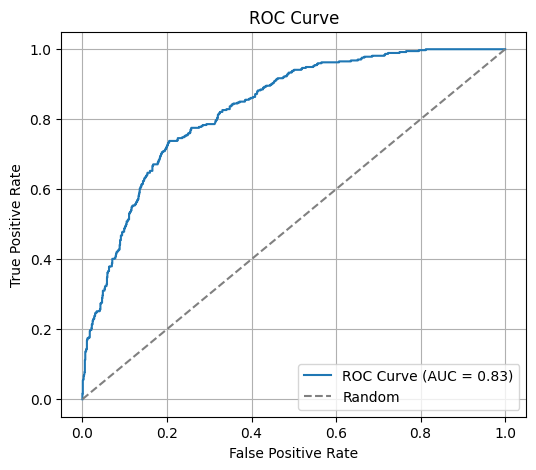

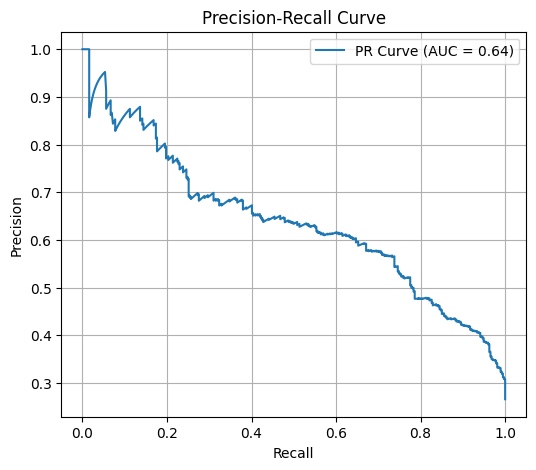


=== Classification Report ===
              precision    recall  f1-score   support

           0      0.814     0.914     0.861      1033
           1      0.641     0.425     0.511       374

    accuracy                          0.784      1407
   macro avg      0.728     0.669     0.686      1407
weighted avg      0.768     0.784     0.768      1407



In [ ]:
# get best estimator
model_gridsearch_best = model_gridsearch.best_estimator_

# Predict gridsearch model
y_pred = model_gridsearch_best.predict(X_test_preprocessed)
y_pred_prob = model_gridsearch_best.predict_proba(X_test_preprocessed)[:, 1]

# 1. Basic metric scores
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_pred_prob)
avg_prec  = average_precision_score(y_test, y_pred_prob)

print("=== Metric Scores ===")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")
print(f"PR AUC:    {avg_prec:.3f}")

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 4. Precision-Recall Curve
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, label=f'PR Curve (AUC = {avg_prec:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# 5. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# Feature Importance

In [ ]:
# get feature importances
print(model_gridsearch_best.n_features_in_)
print(len(model_gridsearch_best.feature_importances_))
print(model_gridsearch_best.feature_importances_)

38
38
[0.14238991 0.04406958 0.09817952 0.00120149 0.0044891  0.00418096
 0.00086274 0.00982253 0.00205214 0.00120051 0.0033068  0.02655053
 0.06513524 0.005957   0.0872945  0.01234611 0.01906317 0.02449802
 0.00927863 0.00604646 0.01417829 0.00695423 0.00223414 0.07844977
 0.01225683 0.02050176 0.0026516  0.00964281 0.00251328 0.00327591
 0.00732421 0.00201817 0.00333014 0.00175549 0.06042543 0.00189558
 0.00426233 0.1984051 ]


In [ ]:
# get feature names
print(len(df_X_train_preprocessed.columns))
print(df_X_train_preprocessed.columns)

38
Index(['num__tenure', 'num__MonthlyCharges', 'num__TotalCharges',
       'bin_cat__gender_Male', 'bin_cat__Partner_Yes',
       'bin_cat__Dependents_Yes', 'bin_cat__PhoneService_Yes',
       'bin_cat__PaperlessBilling_Yes', 'cat__MultipleLines_No',
       'cat__MultipleLines_No phone service', 'cat__MultipleLines_Yes',
       'cat__InternetService_DSL', 'cat__InternetService_Fiber optic',
       'cat__InternetService_No', 'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service', 'cat__OnlineSecurity_Yes',
       'cat__OnlineBackup_No', 'cat__OnlineBackup_No internet service',
       'cat__OnlineBackup_Yes', 'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__StreamingTV_Yes', 'cat__StreamingMovies_No',
       'cat__StreamingMovi

## Plot Feature Importances

/tmp/ipython-input-2627647005.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
/tmp/ipython-input-2627647005.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')


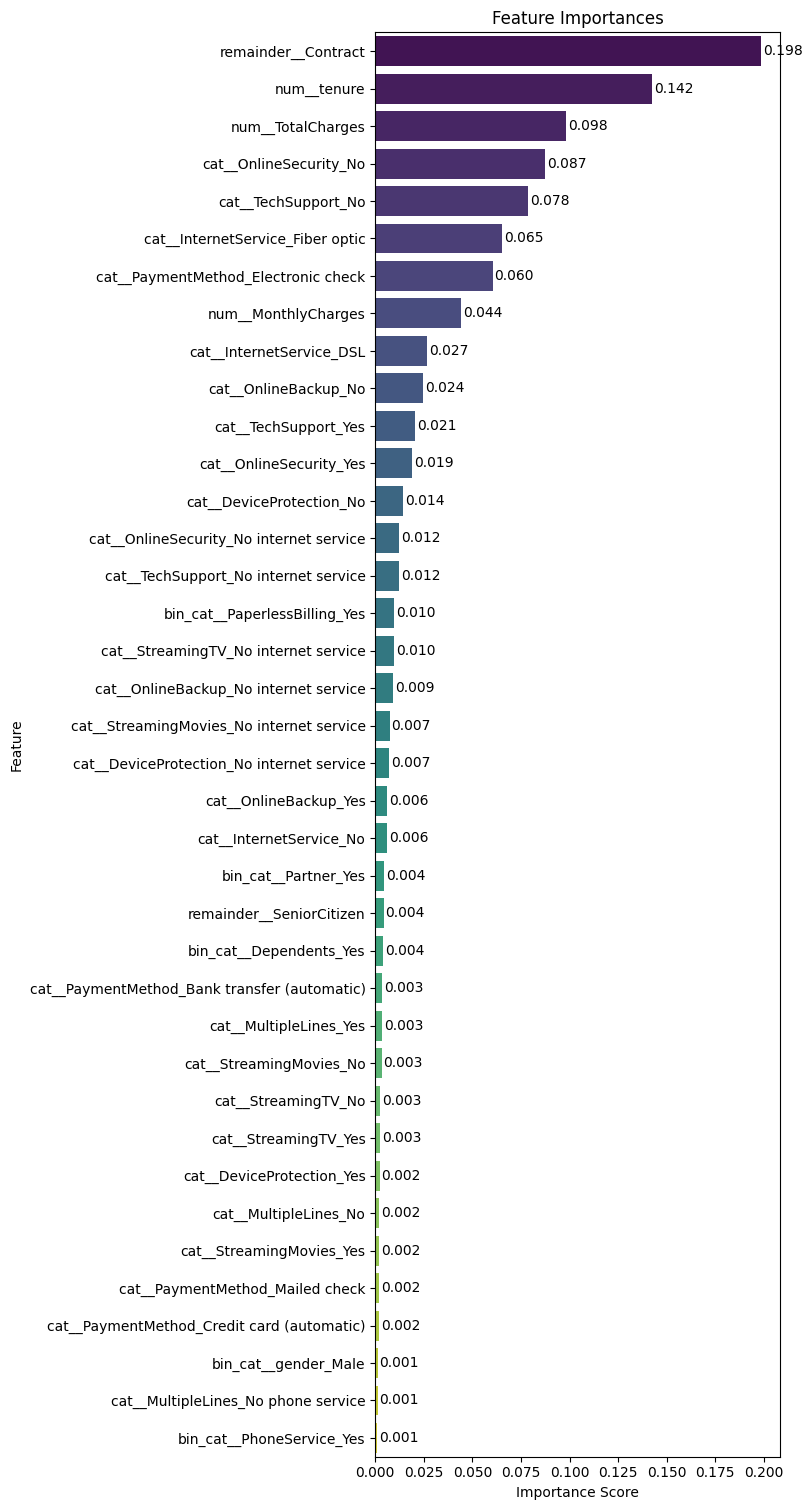

In [ ]:
# get feature importances
importances = model_gridsearch_best.feature_importances_
feature_names = df_X_train_preprocessed.columns

# Create a pandas Series for easy plotting
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, len(feature_names) * 0.4))
sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')
ax = sns.barplot(x=feat_imp, y=feat_imp.index, palette='viridis')

plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
# Add labels to the bars
for i, v in enumerate(feat_imp):
    ax.text(v + 0.001, i, f"{v:.3f}", color='black', va='center')

plt.show()

# Prediction & Feature Diagnostics

In [ ]:
df_X_test_preprocessed

,num__tenure,num__MonthlyCharges,num__TotalCharges,bin_cat__gender_Male,bin_cat__Partner_Yes,bin_cat__Dependents_Yes,bin_cat__PhoneService_Yes,bin_cat__PaperlessBilling_Yes,cat__MultipleLines_No,cat__MultipleLines_No phone service,cat__MultipleLines_Yes,cat__InternetService_DSL,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__PaymentMethod_Bank transfer (automatic),cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,remainder__SeniorCitizen,remainder__Contract
0,1.077320,0.363738,0.984674,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
1,-1.041649,0.450100,-0.781798,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.873573,-1.491376,-0.537223,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
3,-1.245396,-1.473107,-0.994619,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.566313,1.333645,2.308692,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,-0.837902,-0.664297,-0.781182,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1403,-0.267410,-0.637725,-0.507536,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1404,-1.204646,-1.512966,-0.981192,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1405,0.180833,-0.812109,-0.400367,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0


In [ ]:
X_test

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
971,Female,0,Yes,Yes,59,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,2,Yes,Credit card (automatic),75.95,4542.35
618,Female,0,No,No,7,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,0,Yes,Bank transfer (automatic),78.55,522.95
4282,Female,0,No,No,54,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,2,No,Mailed check,20.10,1079.45
3715,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,0,No,Mailed check,20.65,38.70
4525,Female,0,Yes,No,71,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2,Yes,Bank transfer (automatic),105.15,7555.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4821,Female,0,No,No,12,Yes,No,DSL,No,No,No,No,No,No,0,Yes,Bank transfer (automatic),45.00,524.35
5168,Female,0,No,Yes,26,No,No phone service,DSL,Yes,No,No,Yes,No,Yes,0,No,Mailed check,45.80,1147.00
2745,Male,0,No,No,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,Yes,Mailed check,19.45,69.25
4424,Male,0,No,No,37,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,2,Yes,Mailed check,40.55,1390.85


In [ ]:
X_test['y_pred'] = y_pred
X_test['y_pred_prob'] = y_pred_prob

In [ ]:
X_test.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,y_pred,y_pred_prob
971,Female,0,Yes,Yes,59,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,2,Yes,Credit card (automatic),75.95,4542.35,0,0.060069
618,Female,0,No,No,7,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,0,Yes,Bank transfer (automatic),78.55,522.95,1,0.598115
4282,Female,0,No,No,54,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,2,No,Mailed check,20.10,1079.45,0,0.030564
3715,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,0,No,Mailed check,20.65,38.70,0,0.132467
4525,Female,0,Yes,No,71,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2,Yes,Bank transfer (automatic),105.15,7555.00,0,0.192048


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407 entries, 971 to 2086
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1407 non-null   object 
 1   SeniorCitizen     1407 non-null   int64  
 2   Partner           1407 non-null   object 
 3   Dependents        1407 non-null   object 
 4   tenure            1407 non-null   int64  
 5   PhoneService      1407 non-null   object 
 6   MultipleLines     1407 non-null   object 
 7   InternetService   1407 non-null   object 
 8   OnlineSecurity    1407 non-null   object 
 9   OnlineBackup      1407 non-null   object 
 10  DeviceProtection  1407 non-null   object 
 11  TechSupport       1407 non-null   object 
 12  StreamingTV       1407 non-null   object 
 13  StreamingMovies   1407 non-null   object 
 14  Contract          1407 non-null   int64  
 15  PaperlessBilling  1407 non-null   object 
 16  PaymentMethod     1407 non-null   object 
 17

In [ ]:
# Assess feaure/target relationship
  # object columns: mean of y_pred and y_pred_prob
  # int columns: mean of y_pred and y_pred_prob
  # float columns: boxplot by label and lineplot

def explore_feature_relationships(df, target_pred='y_pred', target_prob='y_pred_prob'):
    feature_cols = df.columns.difference([target_pred, target_prob])

    for col in feature_cols:
        dtype = df[col].dtype
        print(f"\n--- Exploring: {col} (type: {dtype}) ---")

        plt.figure(figsize=(10, 5))

        if dtype == 'object' or df[col].nunique() < 10:  # treat low-cardinality numerics as categorical
            # Barplot of mean predicted probability by category
            order = df.groupby(col)[target_prob].mean().sort_values(ascending=False).index
            sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')
            plt.xticks(rotation=45)
            plt.title(f'Mean predicted probability by category: {col}')

        else:
            # Numeric feature — boxplot vs prediction probability
            plt.subplot(1, 2, 1)
            sns.boxplot(x=target_pred, y=col, data=df)
            plt.title(f'{col} distribution by predicted class')

            # Scatterplot of value vs predicted probability
            plt.subplot(1, 2, 2)
            sns.scatterplot(x=col, y=target_prob, data=df, alpha=0.4)
            sns.lineplot(x=col, y=target_prob, data=df.groupby(col)[target_prob].mean().reset_index(), color='red', label='Mean Trend')
            plt.title(f'{col} vs Predicted Probability')

        plt.tight_layout()
        plt.show()


--- Exploring: Contract (type: int64) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


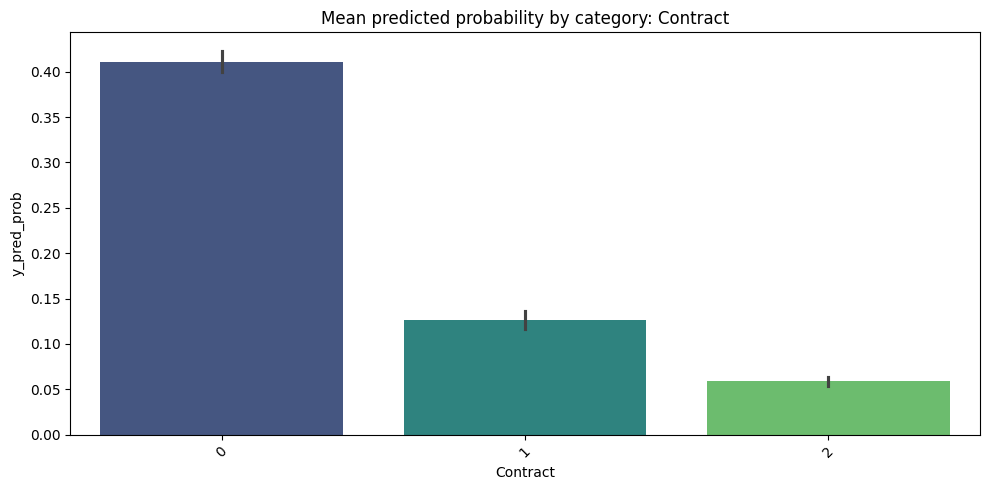


--- Exploring: Dependents (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


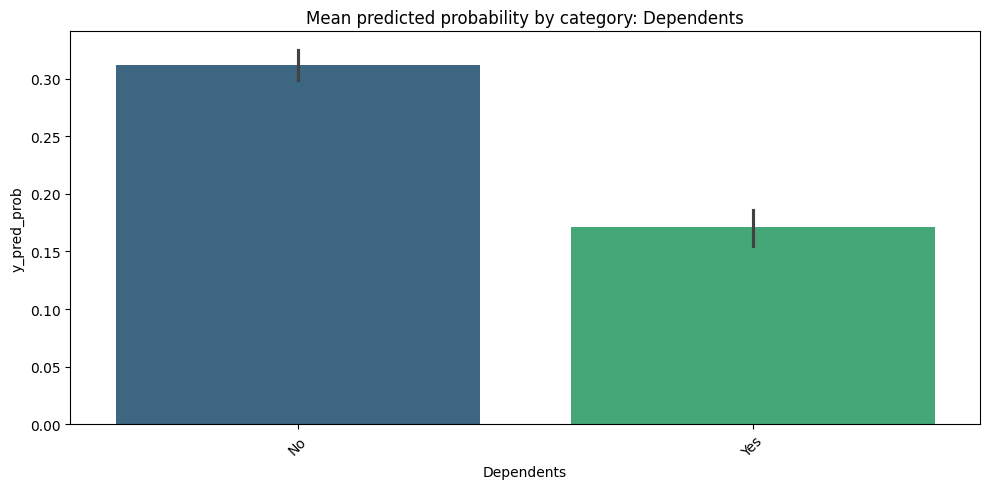


--- Exploring: DeviceProtection (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


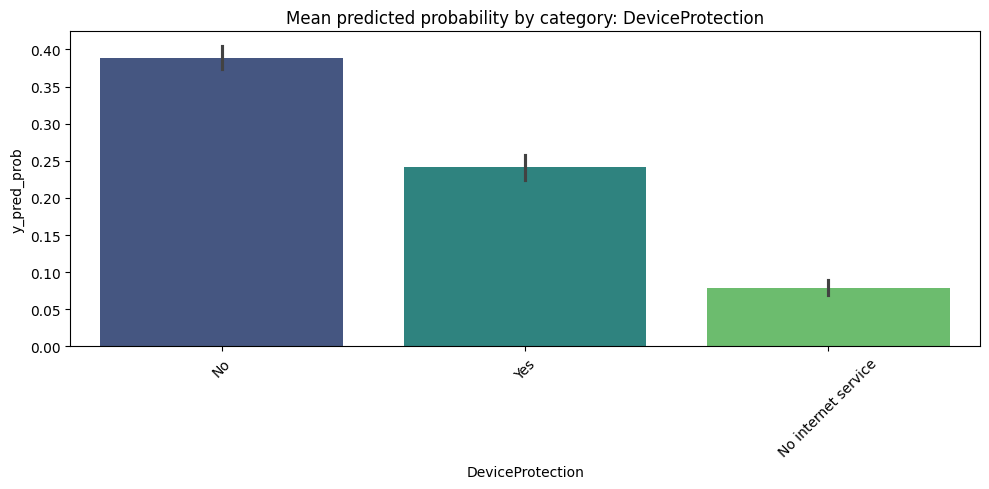


--- Exploring: InternetService (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


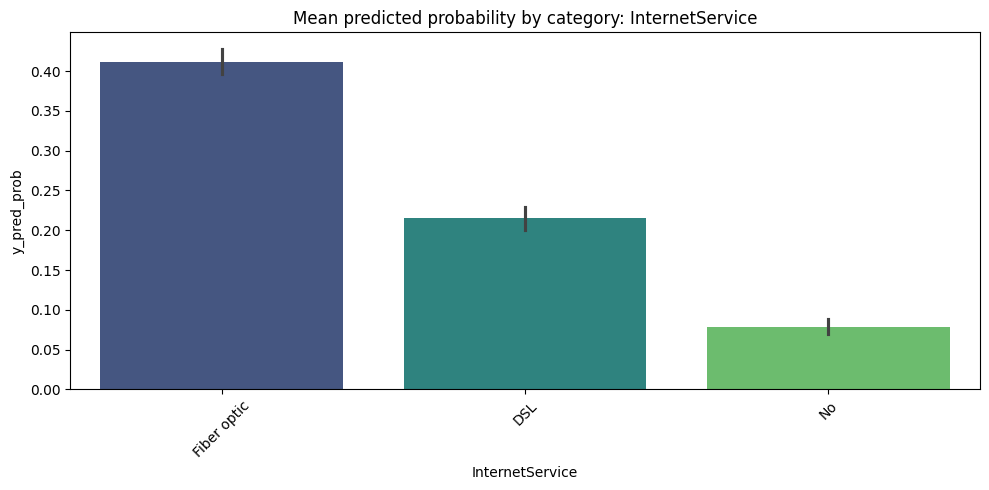


--- Exploring: MonthlyCharges (type: float64) ---


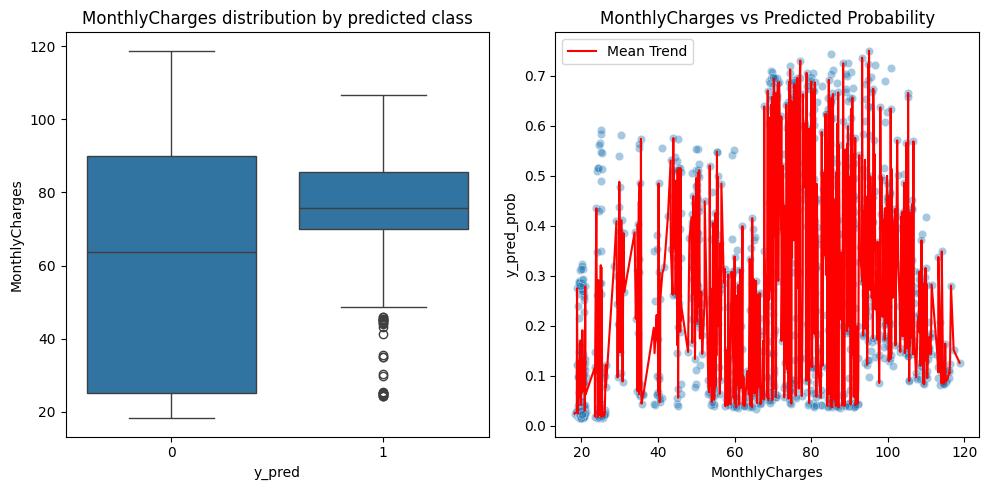


--- Exploring: MultipleLines (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


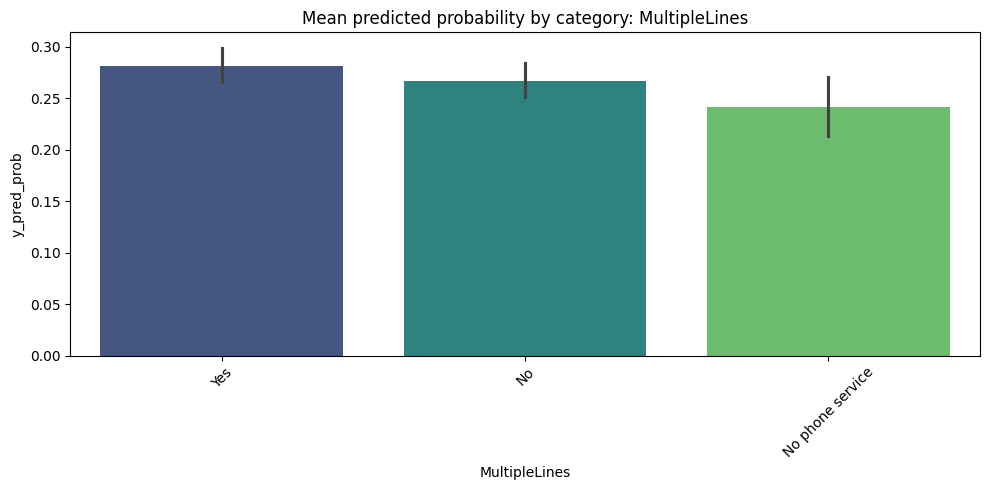


--- Exploring: OnlineBackup (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


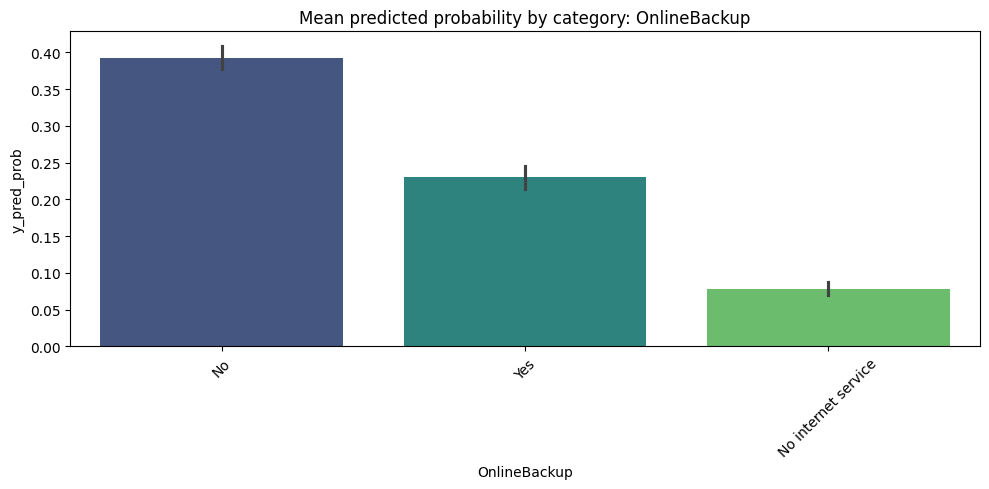


--- Exploring: OnlineSecurity (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


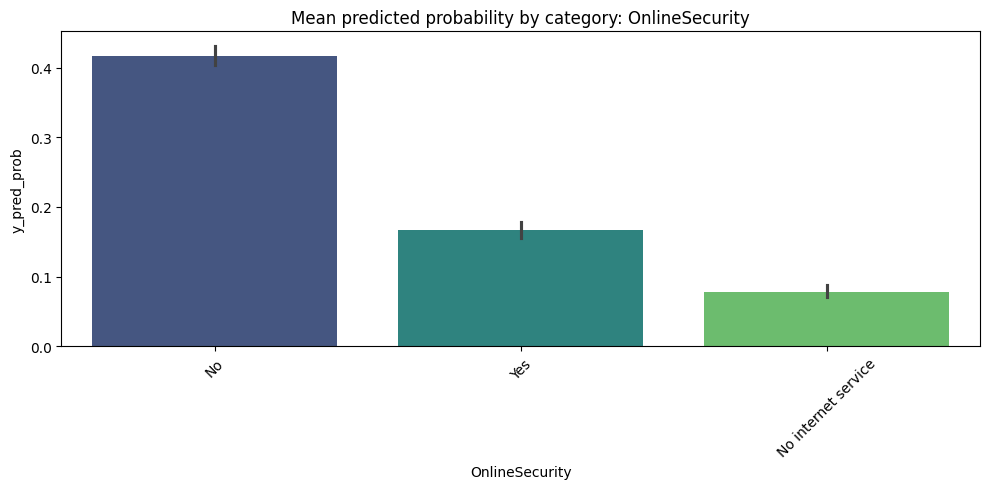


--- Exploring: PaperlessBilling (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


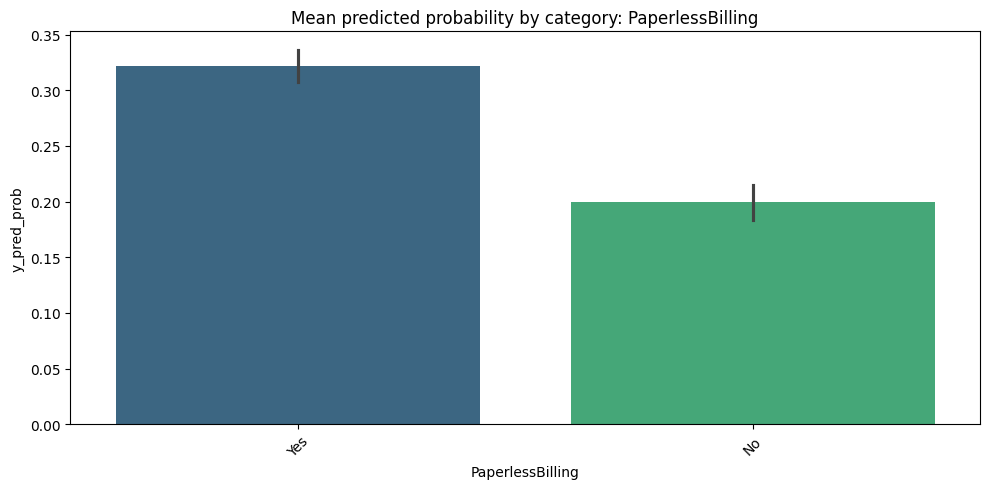


--- Exploring: Partner (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


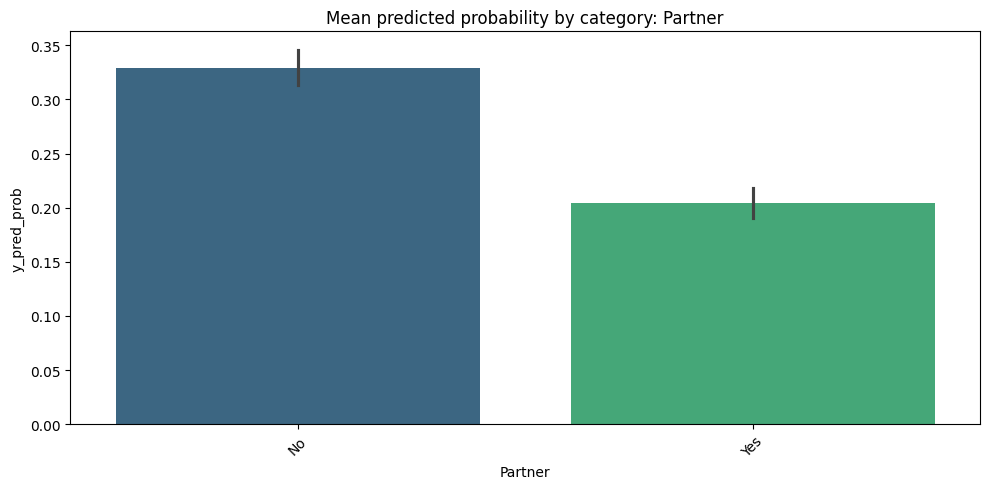


--- Exploring: PaymentMethod (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


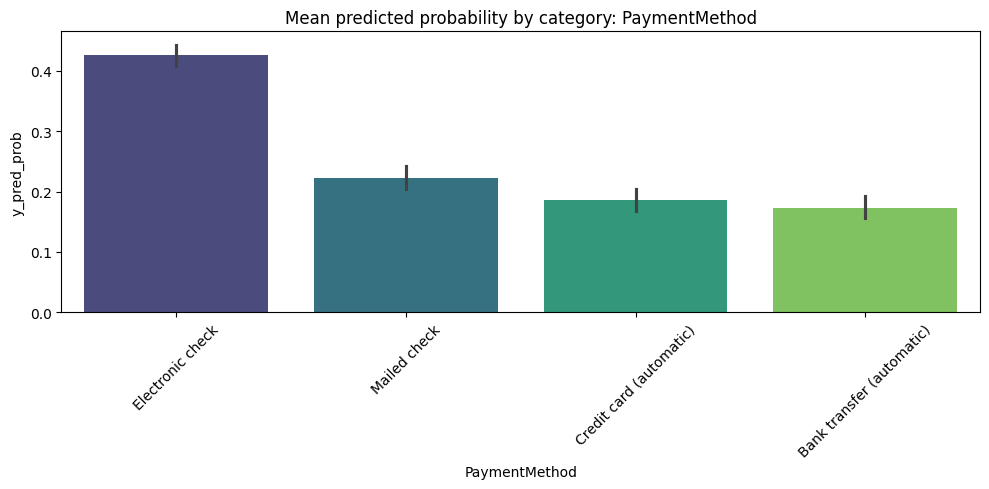


--- Exploring: PhoneService (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


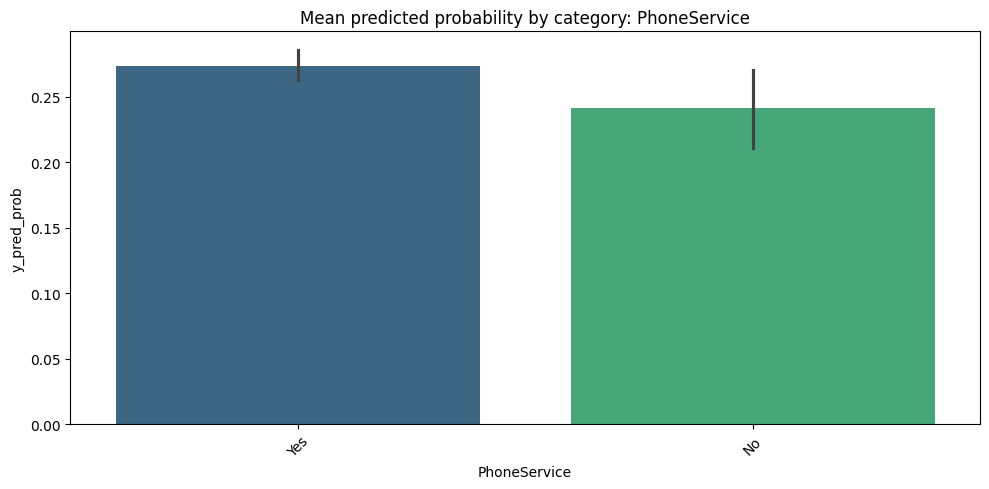


--- Exploring: SeniorCitizen (type: int64) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


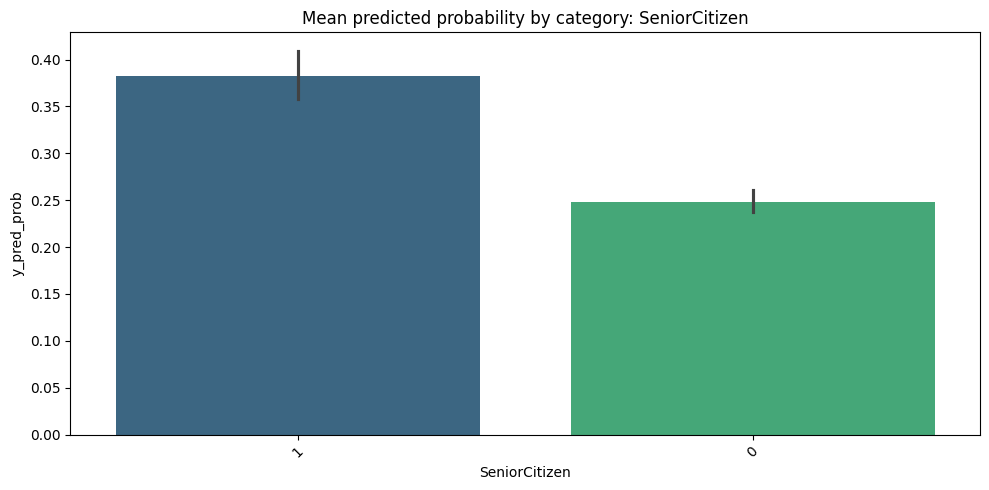


--- Exploring: StreamingMovies (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


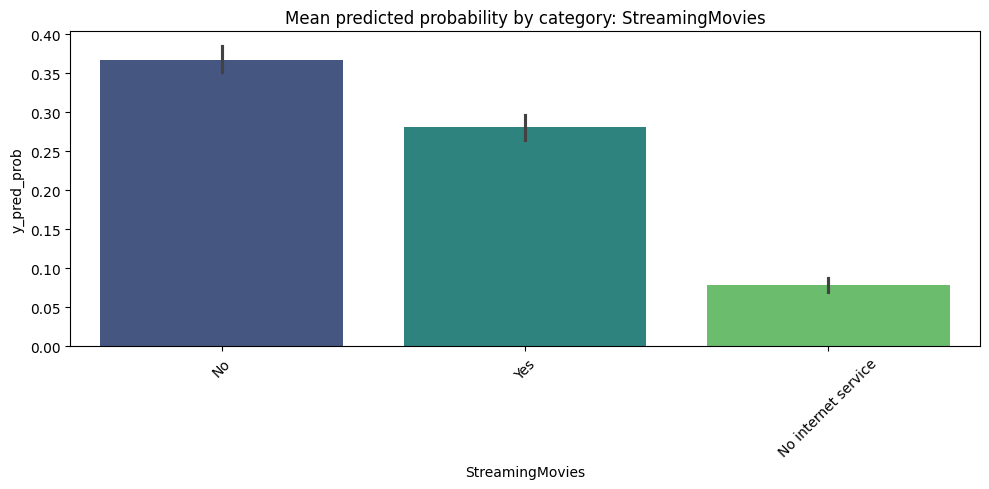


--- Exploring: StreamingTV (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


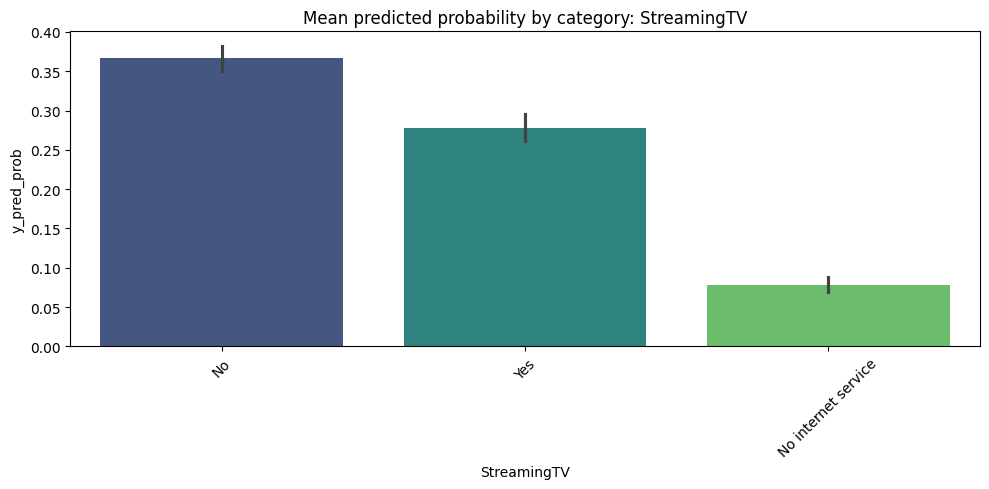


--- Exploring: TechSupport (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


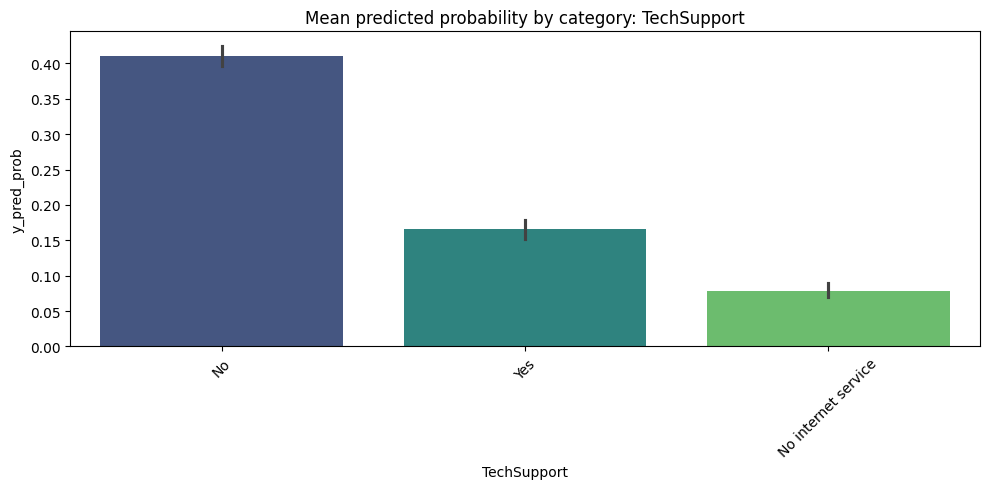


--- Exploring: TotalCharges (type: float64) ---


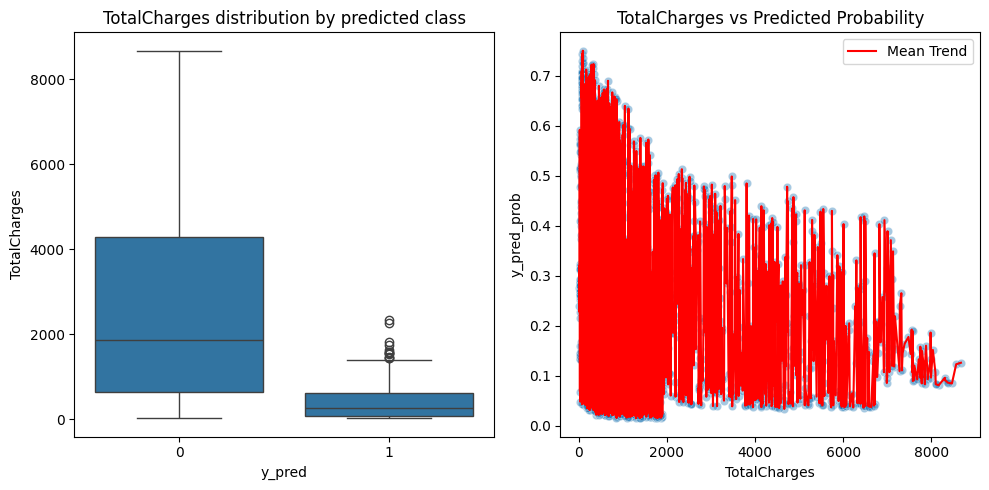


--- Exploring: gender (type: object) ---


/tmp/ipython-input-4137532392.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y=target_prob, data=df, order=order, palette='viridis')


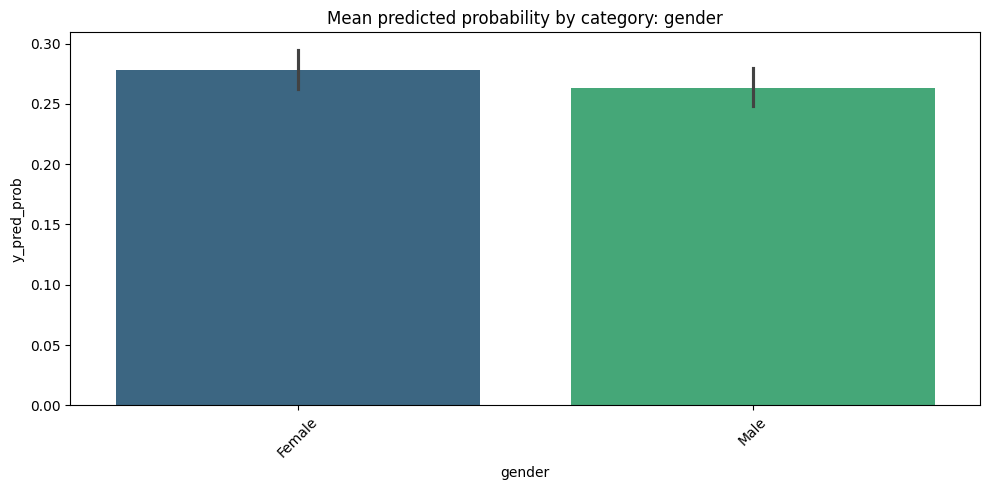


--- Exploring: tenure (type: int64) ---


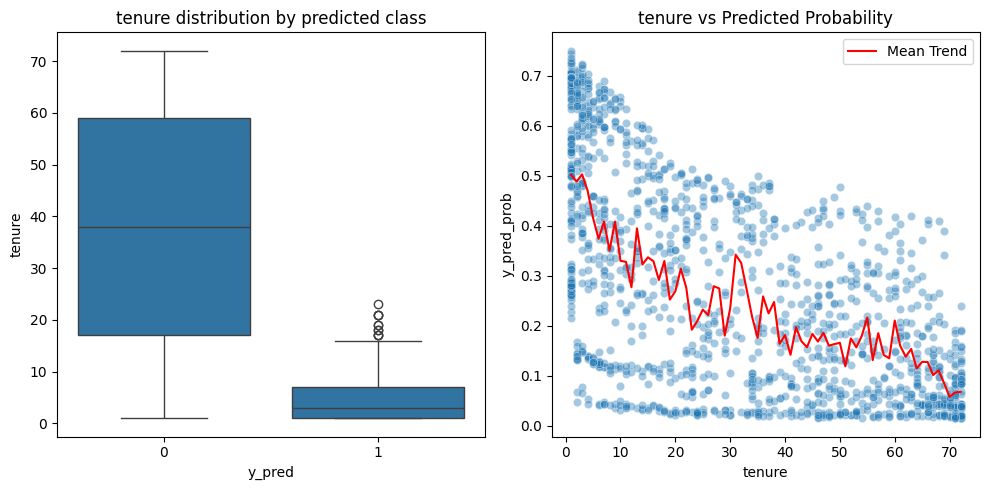

In [ ]:
explore_feature_relationships(X_test)

---